In [ ]:
%pip install tensorflow==2.15.0 opencv-python matplotlib

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

In [7]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [8]:
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')

In [9]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

labelled faces in the wild-<b>negative dataset</b>
http://vis-www.cs.umass.edu/lfw/

In [10]:
!tar -xf lfw.tgz

^C


In [11]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH=os.path.join('lfw',directory,file)
        NEW_PATH=os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)
        

In [12]:
import uuid

In [14]:
os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\98b348e0-90ce-11ee-a845-04421a874b02.jpg'

In [16]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    frame=frame[150:150+250,300:300+250,:]
    
    if cv2.waitKey(1) & 0XFF==ord('a'):
        imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)

    if cv2.waitKey(1) & 0XFF==ord('p'):
        imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    
    cv2.imshow('Image Collection',frame)
    
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [44]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive=tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative=tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [45]:
dir_test=anchor.as_numpy_iterator()

In [46]:
print(dir_test.next())

b'data\\anchor\\4abb4645-90d0-11ee-8a71-04421a874b02.jpg'


In [47]:
def preprocess(file_path):
    byte_img=tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,(100,100))
    img=img/255.0
    return img

0.99338233

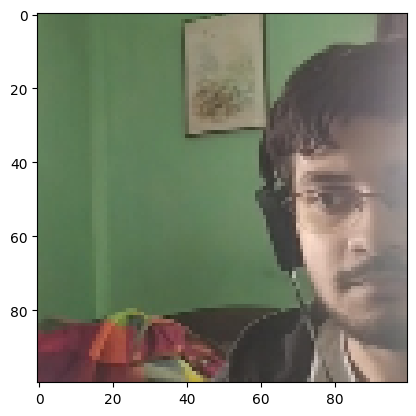

In [48]:
img=preprocess('data\\anchor\\49d356c3-90d0-11ee-90e0-04421a874b02.jpg')
plt.imshow(img)
img.numpy().max()

In [49]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

In [50]:
data
sample=data.as_numpy_iterator()
example=sample.next()
example

(b'data\\anchor\\5fdd0a8d-90d0-11ee-91c5-04421a874b02.jpg',
 b'data\\positive\\7595f2ef-90d0-11ee-9100-04421a874b02.jpg',
 1.0)

In [51]:
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)
res=preprocess_twin(*example)

3


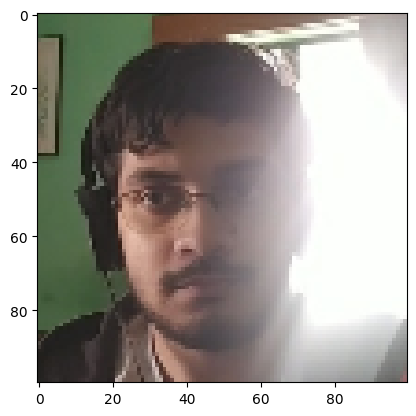

In [52]:
print(len(res))
res[0]
plt.imshow(res[0])

In [53]:
res[2]

1.0

In [60]:
data=data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [82]:
sample=data.as_numpy_iterator()
samp=sample.next()

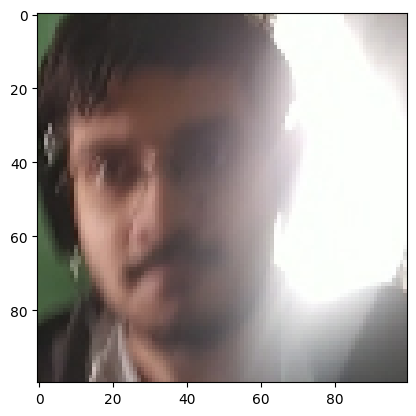

In [83]:
plt.imshow(samp[0])


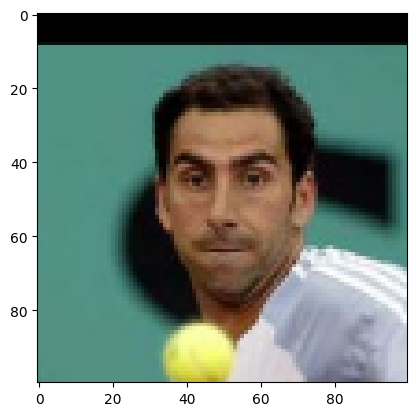

In [84]:
plt.imshow(samp[1])

In [85]:
samp[2]

0.0

In [86]:
train_data=data.take(round(len(data)*0.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [87]:
train_samples=train_data.as_numpy_iterator()
train_samples=train_samples.next()
print(len(train_samples))
print(len(train_samples[0]))


3
16


In [88]:
test_data=data.skip(round(len(data)*7))
test_data=test_data.take(round(len(data)*3))